# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [621]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [622]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [623]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [624]:
def encoder_block(input_layer, filters, strides):
    
    # Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [625]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    #small_conv = separable_conv2d_batchnorm(upsampled, filters, 1)
    #large_conv = separable_conv2d_batchnorm(large_ip_layer, filters, 1)
    
    # Concatenate the upsampled and large input layers using layers.concatenate
    
    #concat = layers.concatenate([small_conv, large_conv])
    concat = layers.concatenate([upsampled, large_ip_layer])
    
    # Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concat, filters, 1)
    
    return output_layer

def decoder_block_lite(small_ip_layer, filters):
    upsampled = bilinear_upsample(small_ip_layer)
    output_layer = separable_conv2d_batchnorm(upsampled,filters,1)
    return output_layer


### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [626]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks
    l1 = encoder_block(inputs, 32, 2)
    l2 = encoder_block(l1, 128, 2)
    l2d = layers.Dropout(0.5)(l2)
    l3 = encoder_block(l2d, 512, 2)
    l3d = layers.Dropout(0.5)(l3)
    
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    l4 = conv2d_batchnorm(l3d, 1024, kernel_size=1, strides=1)
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    l5 = decoder_block(l4, l2, 256)
    l6 = decoder_block(l5, l1, 64)
    x = decoder_block(l6, inputs, 16)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [627]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [628]:
learning_rate = 0.001
batch_size = 32
num_epochs = 100
#steps_per_epoch = 156  # 9987//64
#validation_steps = 39 # 2555//64
steps_per_epoch = 129  # 4131//32
validation_steps = 37 # 1184//32
workers = 2

Epoch 1/100
128/129 [============================>.] - ETA: 0s - loss: 0.7999

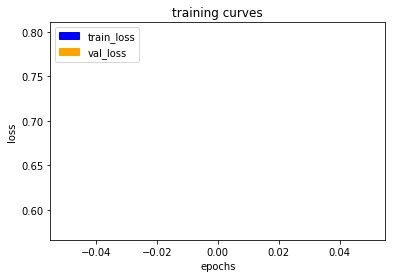

129/129 [==============================] - 69s - loss: 0.7971 - val_loss: 0.5774
Epoch 2/100
128/129 [============================>.] - ETA: 0s - loss: 0.2483

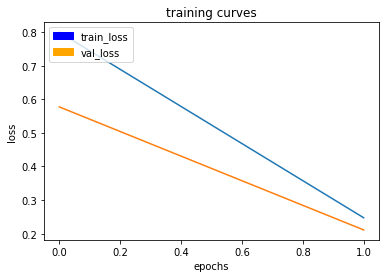

129/129 [==============================] - 66s - loss: 0.2474 - val_loss: 0.2112
Epoch 3/100
128/129 [============================>.] - ETA: 0s - loss: 0.0934

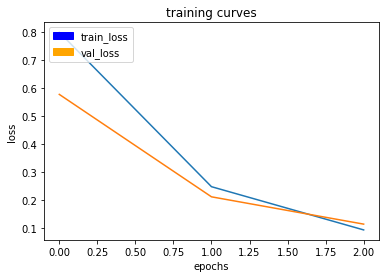

129/129 [==============================] - 65s - loss: 0.0932 - val_loss: 0.1135
Epoch 4/100
128/129 [============================>.] - ETA: 0s - loss: 0.0596

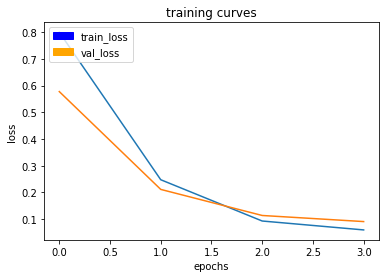

129/129 [==============================] - 66s - loss: 0.0596 - val_loss: 0.0907
Epoch 5/100
128/129 [============================>.] - ETA: 0s - loss: 0.0474

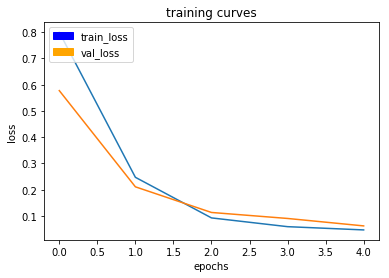

129/129 [==============================] - 68s - loss: 0.0473 - val_loss: 0.0624
Epoch 6/100
128/129 [============================>.] - ETA: 0s - loss: 0.0405

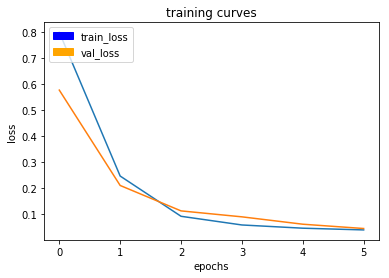

129/129 [==============================] - 67s - loss: 0.0405 - val_loss: 0.0459
Epoch 7/100
128/129 [============================>.] - ETA: 0s - loss: 0.0368

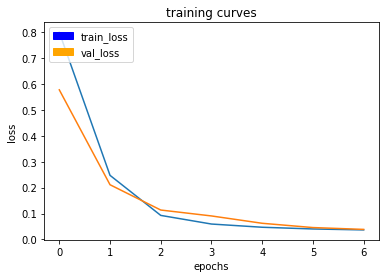

129/129 [==============================] - 65s - loss: 0.0367 - val_loss: 0.0388
Epoch 8/100
128/129 [============================>.] - ETA: 0s - loss: 0.0330

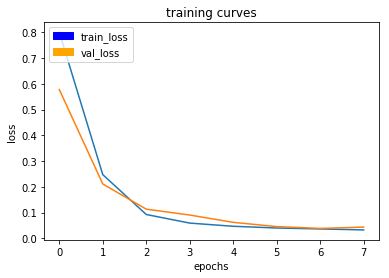

129/129 [==============================] - 65s - loss: 0.0330 - val_loss: 0.0440
Epoch 9/100
128/129 [============================>.] - ETA: 0s - loss: 0.0330

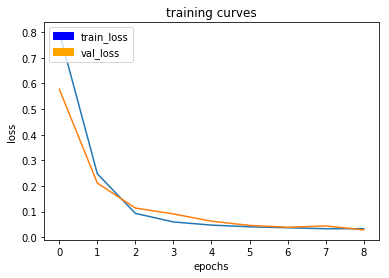

129/129 [==============================] - 65s - loss: 0.0331 - val_loss: 0.0283
Epoch 10/100
128/129 [============================>.] - ETA: 0s - loss: 0.0295

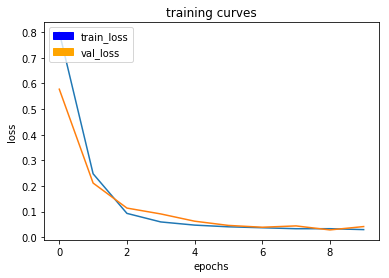

129/129 [==============================] - 65s - loss: 0.0296 - val_loss: 0.0414
Epoch 11/100
128/129 [============================>.] - ETA: 0s - loss: 0.0290

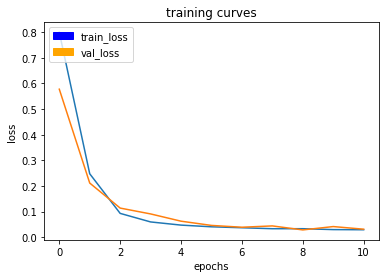

129/129 [==============================] - 65s - loss: 0.0290 - val_loss: 0.0312
Epoch 12/100
128/129 [============================>.] - ETA: 0s - loss: 0.0322

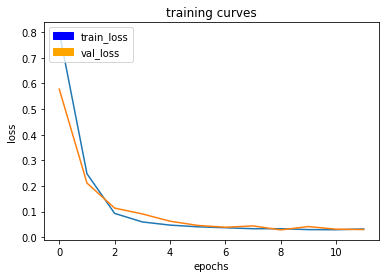

129/129 [==============================] - 65s - loss: 0.0321 - val_loss: 0.0298
Epoch 13/100
128/129 [============================>.] - ETA: 0s - loss: 0.0265

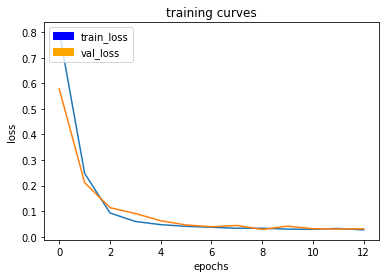

129/129 [==============================] - 65s - loss: 0.0264 - val_loss: 0.0311
Epoch 14/100
128/129 [============================>.] - ETA: 0s - loss: 0.0263

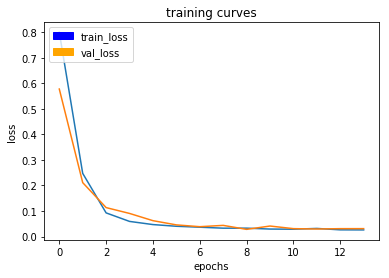

129/129 [==============================] - 65s - loss: 0.0262 - val_loss: 0.0312
Epoch 15/100
128/129 [============================>.] - ETA: 0s - loss: 0.0252

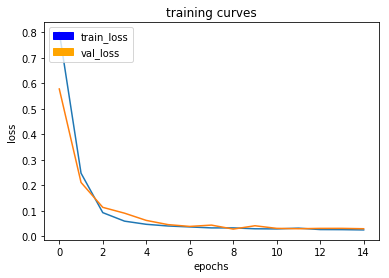

129/129 [==============================] - 65s - loss: 0.0252 - val_loss: 0.0298
Epoch 16/100
128/129 [============================>.] - ETA: 0s - loss: 0.0236

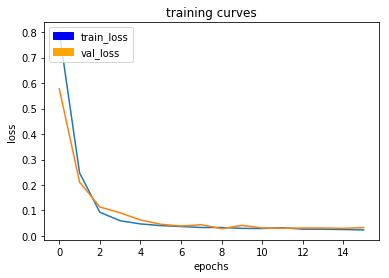

129/129 [==============================] - 65s - loss: 0.0235 - val_loss: 0.0328
Epoch 17/100
128/129 [============================>.] - ETA: 0s - loss: 0.0235

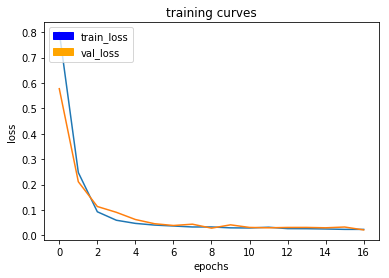

129/129 [==============================] - 65s - loss: 0.0235 - val_loss: 0.0214
Epoch 18/100
128/129 [============================>.] - ETA: 0s - loss: 0.0235

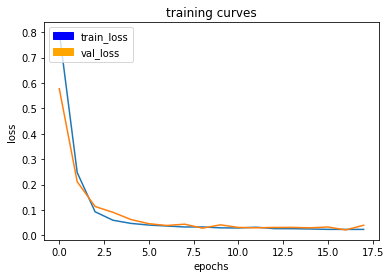

129/129 [==============================] - 66s - loss: 0.0235 - val_loss: 0.0398
Epoch 19/100
128/129 [============================>.] - ETA: 0s - loss: 0.0229

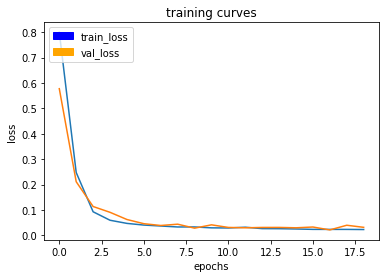

129/129 [==============================] - 68s - loss: 0.0229 - val_loss: 0.0316
Epoch 20/100
128/129 [============================>.] - ETA: 0s - loss: 0.0210

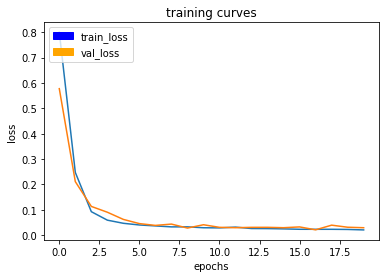

129/129 [==============================] - 67s - loss: 0.0210 - val_loss: 0.0297
Epoch 21/100
128/129 [============================>.] - ETA: 0s - loss: 0.0214

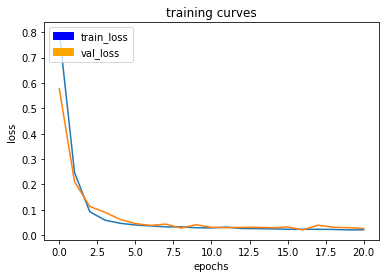

129/129 [==============================] - 67s - loss: 0.0213 - val_loss: 0.0267
Epoch 22/100
128/129 [============================>.] - ETA: 0s - loss: 0.0217

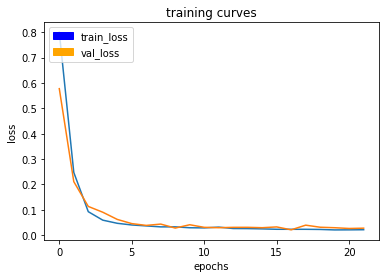

129/129 [==============================] - 67s - loss: 0.0217 - val_loss: 0.0279
Epoch 23/100
128/129 [============================>.] - ETA: 0s - loss: 0.0198

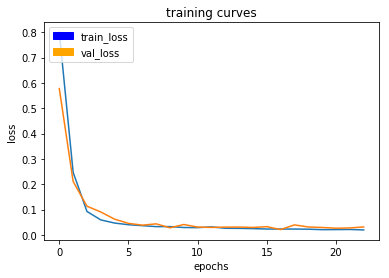

129/129 [==============================] - 67s - loss: 0.0200 - val_loss: 0.0317
Epoch 24/100
128/129 [============================>.] - ETA: 0s - loss: 0.0214

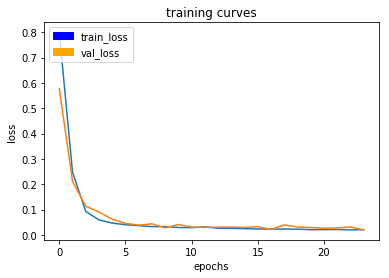

129/129 [==============================] - 67s - loss: 0.0213 - val_loss: 0.0201
Epoch 25/100
128/129 [============================>.] - ETA: 0s - loss: 0.0199

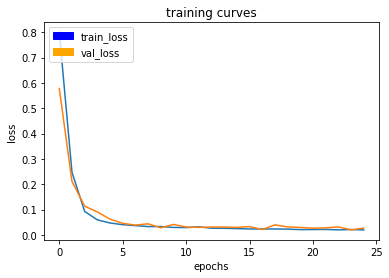

129/129 [==============================] - 66s - loss: 0.0198 - val_loss: 0.0269
Epoch 26/100
128/129 [============================>.] - ETA: 0s - loss: 0.0191

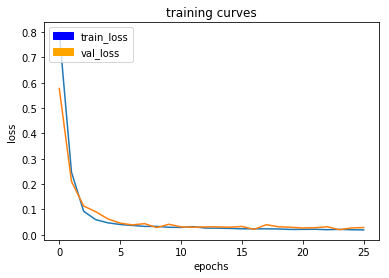

129/129 [==============================] - 65s - loss: 0.0191 - val_loss: 0.0286
Epoch 27/100
128/129 [============================>.] - ETA: 0s - loss: 0.0196

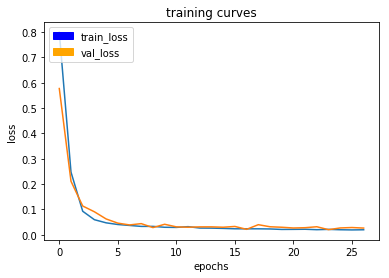

129/129 [==============================] - 65s - loss: 0.0197 - val_loss: 0.0264
Epoch 28/100
128/129 [============================>.] - ETA: 0s - loss: 0.0199

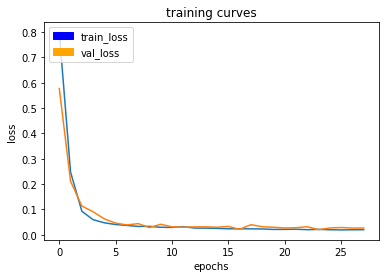

129/129 [==============================] - 65s - loss: 0.0199 - val_loss: 0.0268
Epoch 29/100
128/129 [============================>.] - ETA: 0s - loss: 0.0181

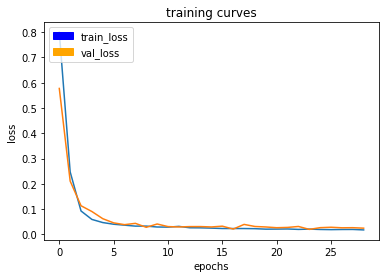

129/129 [==============================] - 65s - loss: 0.0180 - val_loss: 0.0249
Epoch 30/100
128/129 [============================>.] - ETA: 0s - loss: 0.0187

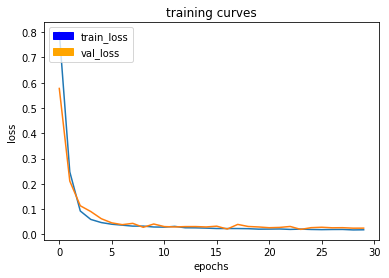

129/129 [==============================] - 65s - loss: 0.0187 - val_loss: 0.0250
Epoch 31/100
128/129 [============================>.] - ETA: 0s - loss: 0.0179

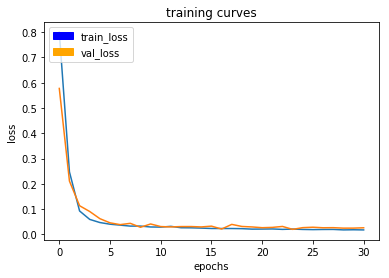

129/129 [==============================] - 65s - loss: 0.0179 - val_loss: 0.0263
Epoch 32/100
128/129 [============================>.] - ETA: 0s - loss: 0.0180

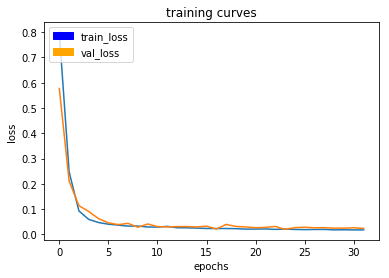

129/129 [==============================] - 66s - loss: 0.0180 - val_loss: 0.0240
Epoch 33/100
128/129 [============================>.] - ETA: 0s - loss: 0.0169

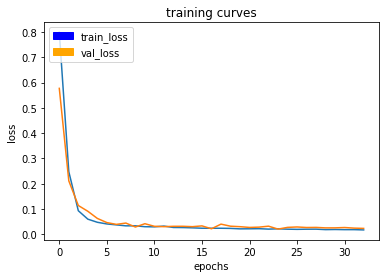

129/129 [==============================] - 67s - loss: 0.0169 - val_loss: 0.0229
Epoch 34/100
128/129 [============================>.] - ETA: 0s - loss: 0.0192

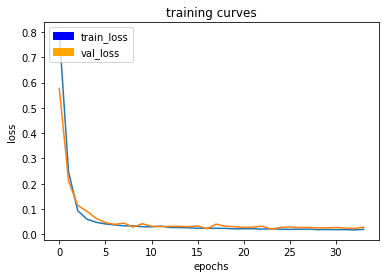

129/129 [==============================] - 67s - loss: 0.0192 - val_loss: 0.0275
Epoch 35/100
128/129 [============================>.] - ETA: 0s - loss: 0.0172

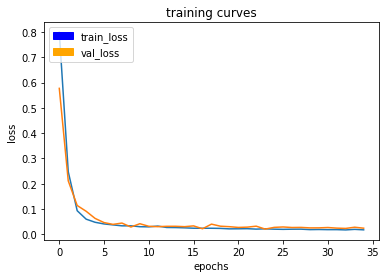

129/129 [==============================] - 67s - loss: 0.0172 - val_loss: 0.0237
Epoch 36/100
128/129 [============================>.] - ETA: 0s - loss: 0.0181

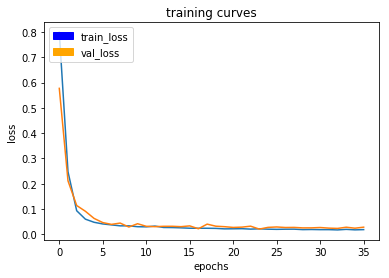

129/129 [==============================] - 67s - loss: 0.0180 - val_loss: 0.0277
Epoch 37/100
128/129 [============================>.] - ETA: 0s - loss: 0.0174

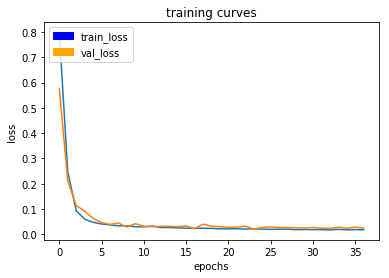

129/129 [==============================] - 67s - loss: 0.0174 - val_loss: 0.0234
Epoch 38/100
128/129 [============================>.] - ETA: 0s - loss: 0.0176

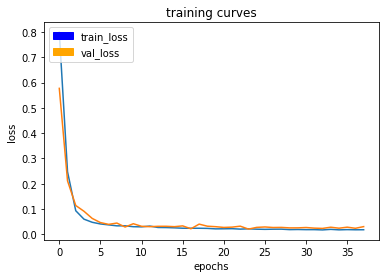

129/129 [==============================] - 67s - loss: 0.0176 - val_loss: 0.0299
Epoch 39/100
128/129 [============================>.] - ETA: 0s - loss: 0.0163

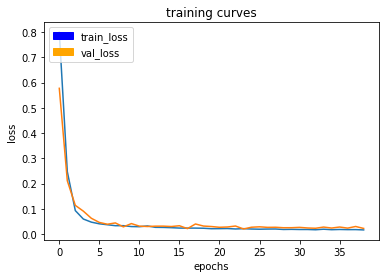

129/129 [==============================] - 67s - loss: 0.0163 - val_loss: 0.0222
Epoch 40/100
128/129 [============================>.] - ETA: 0s - loss: 0.0166

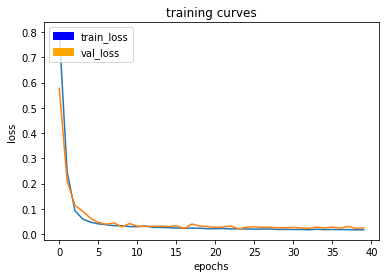

129/129 [==============================] - 67s - loss: 0.0165 - val_loss: 0.0242
Epoch 41/100
128/129 [============================>.] - ETA: 0s - loss: 0.0157

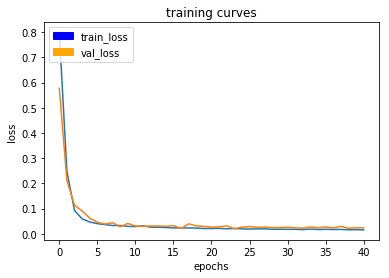

129/129 [==============================] - 67s - loss: 0.0156 - val_loss: 0.0236
Epoch 42/100
128/129 [============================>.] - ETA: 0s - loss: 0.0182

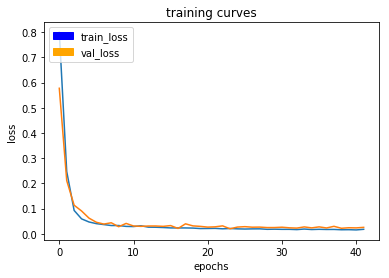

129/129 [==============================] - 67s - loss: 0.0181 - val_loss: 0.0258
Epoch 43/100
128/129 [============================>.] - ETA: 0s - loss: 0.0157

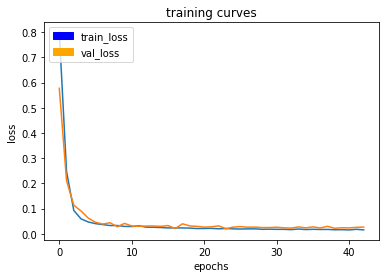

129/129 [==============================] - 67s - loss: 0.0157 - val_loss: 0.0269
Epoch 44/100
128/129 [============================>.] - ETA: 0s - loss: 0.0157

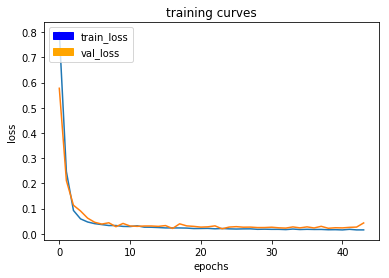

129/129 [==============================] - 67s - loss: 0.0157 - val_loss: 0.0433
Epoch 45/100
128/129 [============================>.] - ETA: 0s - loss: 0.0154

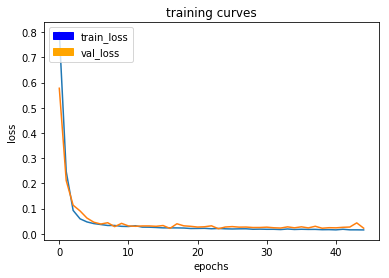

129/129 [==============================] - 67s - loss: 0.0154 - val_loss: 0.0223
Epoch 46/100
128/129 [============================>.] - ETA: 0s - loss: 0.0181

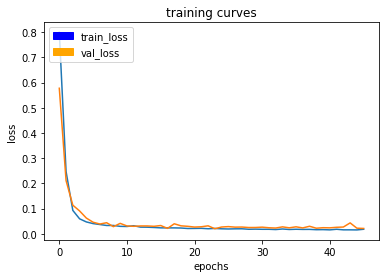

129/129 [==============================] - 67s - loss: 0.0180 - val_loss: 0.0212
Epoch 47/100
128/129 [============================>.] - ETA: 0s - loss: 0.0145

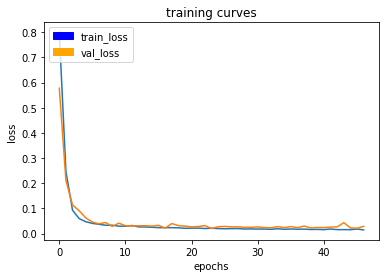

129/129 [==============================] - 67s - loss: 0.0145 - val_loss: 0.0287
Epoch 48/100
128/129 [============================>.] - ETA: 0s - loss: 0.0149

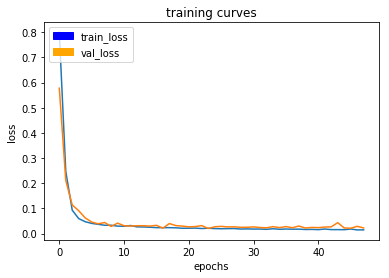

129/129 [==============================] - 67s - loss: 0.0149 - val_loss: 0.0224
Epoch 49/100
128/129 [============================>.] - ETA: 0s - loss: 0.0159

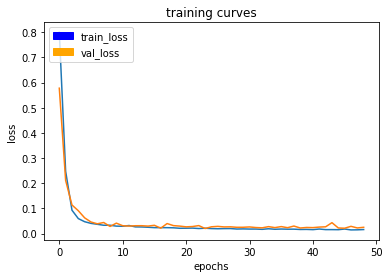

129/129 [==============================] - 67s - loss: 0.0159 - val_loss: 0.0249
Epoch 50/100
128/129 [============================>.] - ETA: 0s - loss: 0.0152

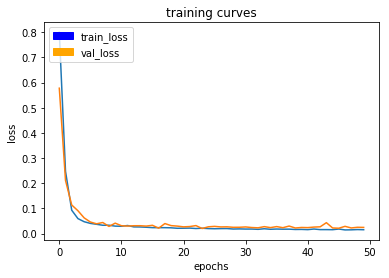

129/129 [==============================] - 67s - loss: 0.0153 - val_loss: 0.0245
Epoch 51/100
128/129 [============================>.] - ETA: 0s - loss: 0.0149

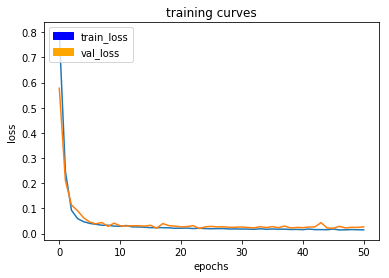

129/129 [==============================] - 67s - loss: 0.0149 - val_loss: 0.0266
Epoch 52/100
128/129 [============================>.] - ETA: 0s - loss: 0.0138

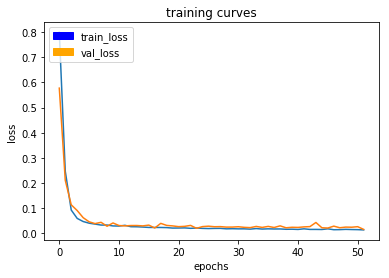

129/129 [==============================] - 67s - loss: 0.0138 - val_loss: 0.0158
Epoch 53/100
128/129 [============================>.] - ETA: 0s - loss: 0.0154

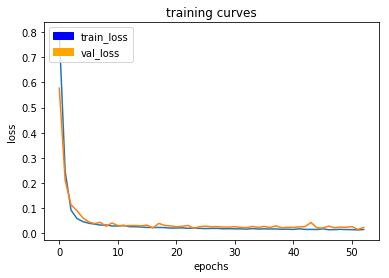

129/129 [==============================] - 67s - loss: 0.0153 - val_loss: 0.0231
Epoch 54/100
128/129 [============================>.] - ETA: 0s - loss: 0.0145

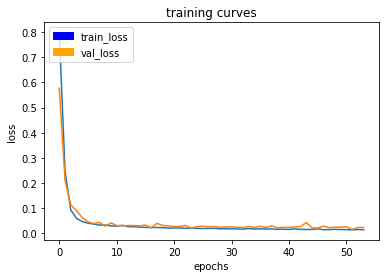

129/129 [==============================] - 67s - loss: 0.0145 - val_loss: 0.0238
Epoch 55/100
128/129 [============================>.] - ETA: 0s - loss: 0.0155

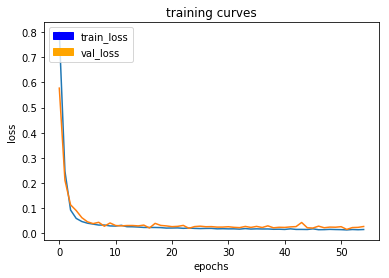

129/129 [==============================] - 67s - loss: 0.0155 - val_loss: 0.0273
Epoch 56/100
128/129 [============================>.] - ETA: 0s - loss: 0.0148

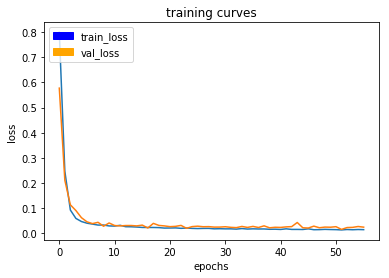

129/129 [==============================] - 67s - loss: 0.0147 - val_loss: 0.0247
Epoch 57/100
128/129 [============================>.] - ETA: 0s - loss: 0.0147

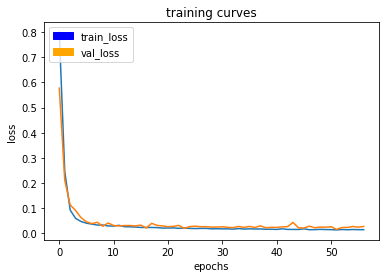

129/129 [==============================] - 67s - loss: 0.0147 - val_loss: 0.0274
Epoch 58/100
128/129 [============================>.] - ETA: 0s - loss: 0.0136

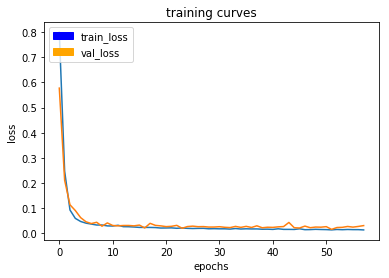

129/129 [==============================] - 67s - loss: 0.0136 - val_loss: 0.0308
Epoch 59/100
128/129 [============================>.] - ETA: 0s - loss: 0.0156

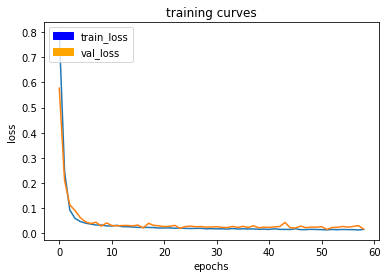

129/129 [==============================] - 67s - loss: 0.0155 - val_loss: 0.0166
Epoch 60/100
128/129 [============================>.] - ETA: 0s - loss: 0.0133

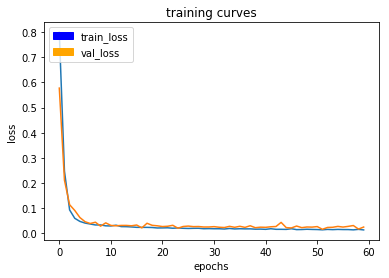

129/129 [==============================] - 67s - loss: 0.0133 - val_loss: 0.0247
Epoch 61/100
128/129 [============================>.] - ETA: 0s - loss: 0.0134

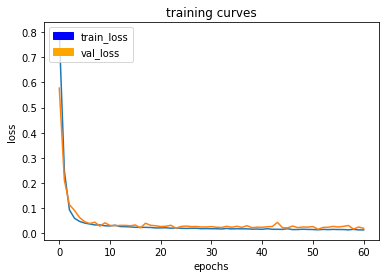

129/129 [==============================] - 67s - loss: 0.0134 - val_loss: 0.0196
Epoch 62/100
128/129 [============================>.] - ETA: 0s - loss: 0.0134

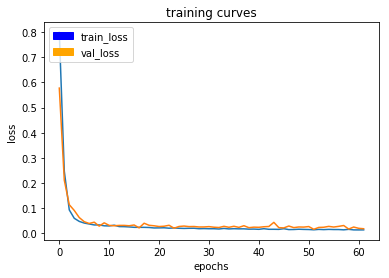

129/129 [==============================] - 67s - loss: 0.0134 - val_loss: 0.0180
Epoch 63/100
128/129 [============================>.] - ETA: 0s - loss: 0.0129

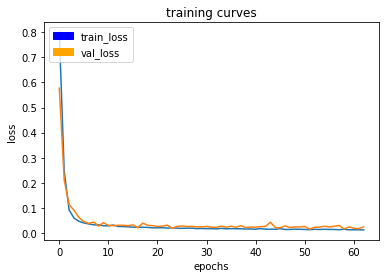

129/129 [==============================] - 67s - loss: 0.0129 - val_loss: 0.0249
Epoch 64/100
128/129 [============================>.] - ETA: 0s - loss: 0.0147

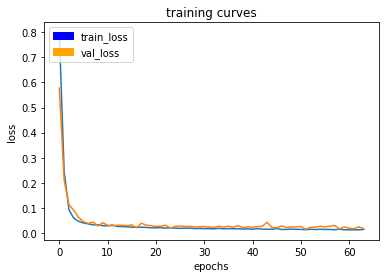

129/129 [==============================] - 67s - loss: 0.0147 - val_loss: 0.0177
Epoch 65/100
128/129 [============================>.] - ETA: 0s - loss: 0.0128

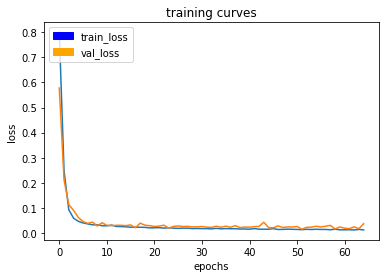

129/129 [==============================] - 67s - loss: 0.0128 - val_loss: 0.0376
Epoch 66/100
128/129 [============================>.] - ETA: 0s - loss: 0.0132

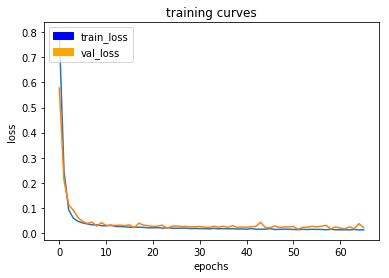

129/129 [==============================] - 67s - loss: 0.0132 - val_loss: 0.0219
Epoch 67/100
128/129 [============================>.] - ETA: 0s - loss: 0.0132

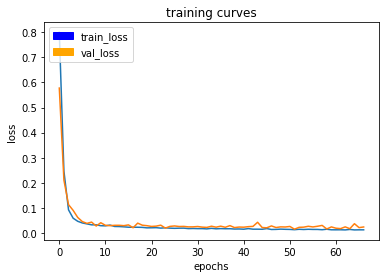

129/129 [==============================] - 67s - loss: 0.0132 - val_loss: 0.0245
Epoch 68/100
128/129 [============================>.] - ETA: 0s - loss: 0.0128

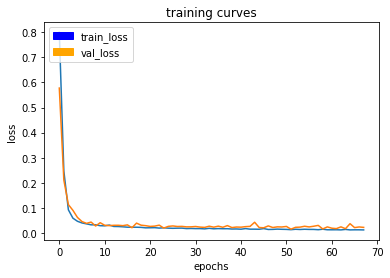

129/129 [==============================] - 67s - loss: 0.0128 - val_loss: 0.0228
Epoch 69/100
128/129 [============================>.] - ETA: 0s - loss: 0.0130

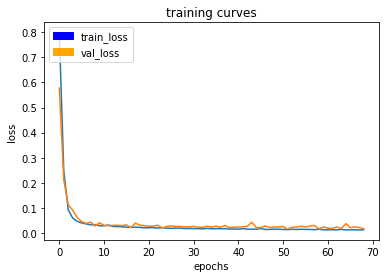

129/129 [==============================] - 67s - loss: 0.0130 - val_loss: 0.0173
Epoch 70/100
128/129 [============================>.] - ETA: 0s - loss: 0.0132

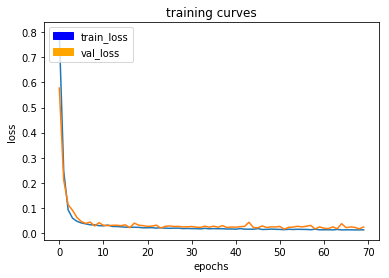

129/129 [==============================] - 67s - loss: 0.0132 - val_loss: 0.0244
Epoch 71/100
128/129 [============================>.] - ETA: 0s - loss: 0.0142

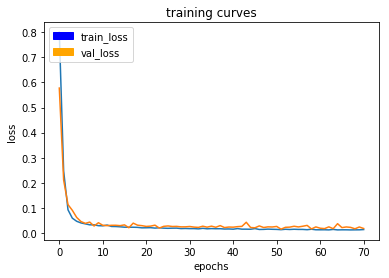

129/129 [==============================] - 67s - loss: 0.0142 - val_loss: 0.0185
Epoch 72/100
128/129 [============================>.] - ETA: 0s - loss: 0.0142

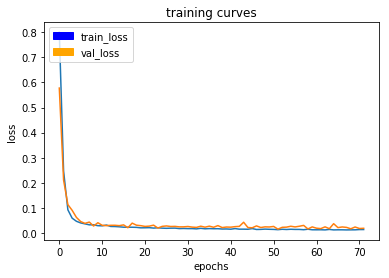

129/129 [==============================] - 67s - loss: 0.0142 - val_loss: 0.0193
Epoch 73/100
128/129 [============================>.] - ETA: 0s - loss: 0.0153

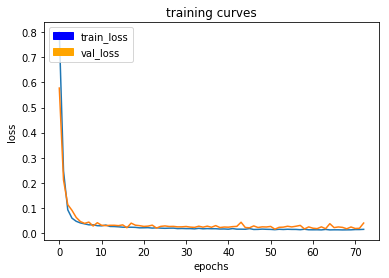

129/129 [==============================] - 67s - loss: 0.0153 - val_loss: 0.0401
Epoch 74/100
128/129 [============================>.] - ETA: 0s - loss: 0.0140

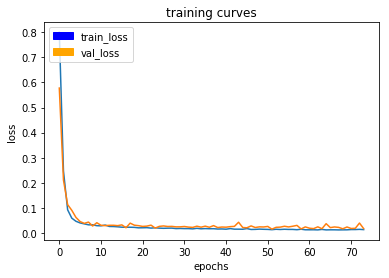

129/129 [==============================] - 67s - loss: 0.0139 - val_loss: 0.0180
Epoch 75/100
128/129 [============================>.] - ETA: 0s - loss: 0.0128

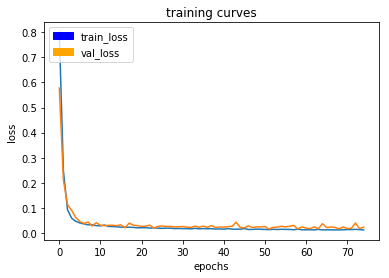

129/129 [==============================] - 67s - loss: 0.0128 - val_loss: 0.0240
Epoch 76/100
128/129 [============================>.] - ETA: 0s - loss: 0.0141

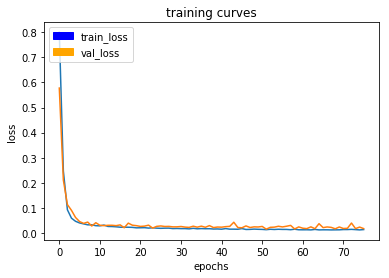

129/129 [==============================] - 67s - loss: 0.0141 - val_loss: 0.0180
Epoch 77/100
128/129 [============================>.] - ETA: 0s - loss: 0.0146

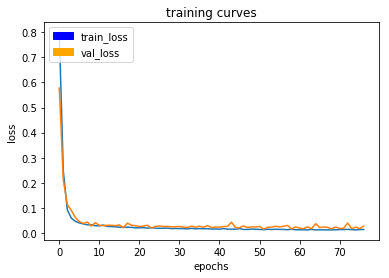

129/129 [==============================] - 67s - loss: 0.0146 - val_loss: 0.0277
Epoch 78/100
128/129 [============================>.] - ETA: 0s - loss: 0.0129

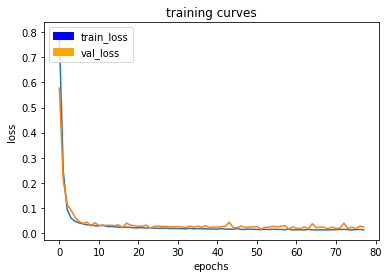

129/129 [==============================] - 67s - loss: 0.0130 - val_loss: 0.0249
Epoch 79/100
128/129 [============================>.] - ETA: 0s - loss: 0.0133

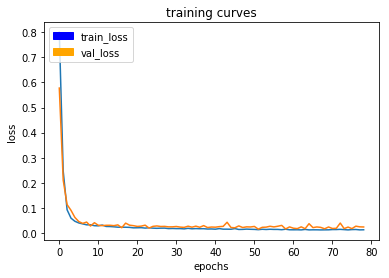

129/129 [==============================] - 67s - loss: 0.0133 - val_loss: 0.0244
Epoch 80/100
128/129 [============================>.] - ETA: 0s - loss: 0.0132

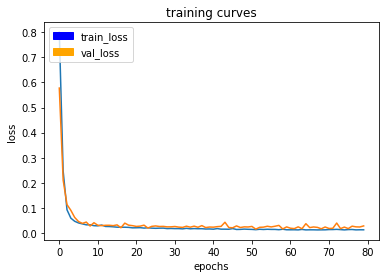

129/129 [==============================] - 67s - loss: 0.0132 - val_loss: 0.0287
Epoch 81/100
128/129 [============================>.] - ETA: 0s - loss: 0.0120

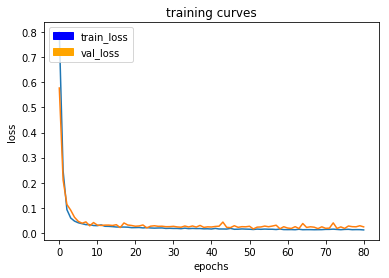

129/129 [==============================] - 67s - loss: 0.0120 - val_loss: 0.0241
Epoch 82/100
128/129 [============================>.] - ETA: 0s - loss: 0.0133

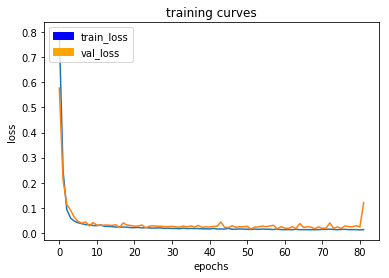

129/129 [==============================] - 67s - loss: 0.0133 - val_loss: 0.1209
Epoch 83/100
128/129 [============================>.] - ETA: 0s - loss: 0.0126

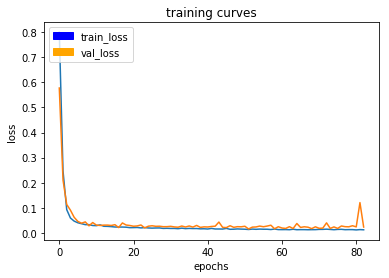

129/129 [==============================] - 65s - loss: 0.0126 - val_loss: 0.0234
Epoch 84/100
128/129 [============================>.] - ETA: 0s - loss: 0.0130

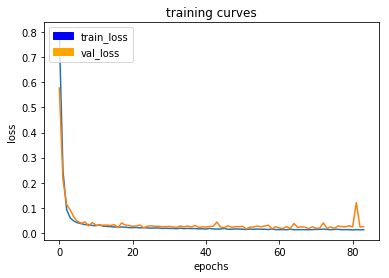

129/129 [==============================] - 65s - loss: 0.0129 - val_loss: 0.0248
Epoch 85/100
128/129 [============================>.] - ETA: 0s - loss: 0.0128

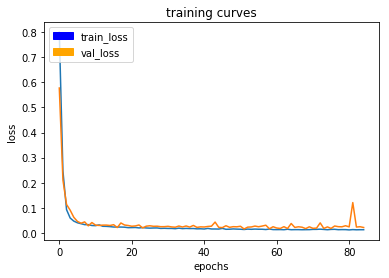

129/129 [==============================] - 65s - loss: 0.0128 - val_loss: 0.0217
Epoch 86/100
128/129 [============================>.] - ETA: 0s - loss: 0.0124

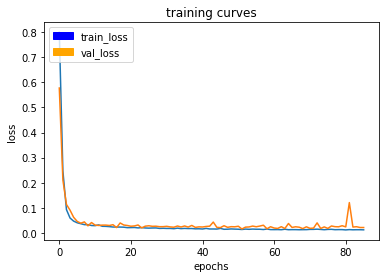

129/129 [==============================] - 65s - loss: 0.0124 - val_loss: 0.0216
Epoch 87/100
128/129 [============================>.] - ETA: 0s - loss: 0.0120

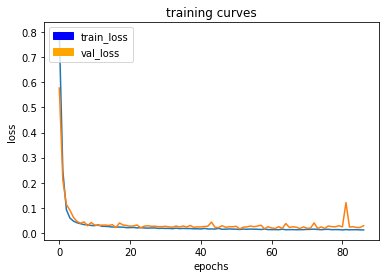

129/129 [==============================] - 65s - loss: 0.0120 - val_loss: 0.0288
Epoch 88/100
128/129 [============================>.] - ETA: 0s - loss: 0.0123

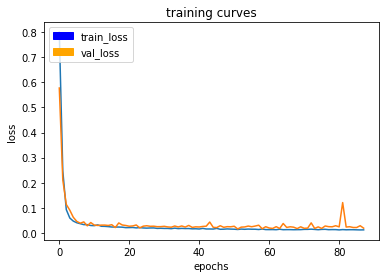

129/129 [==============================] - 65s - loss: 0.0123 - val_loss: 0.0190
Epoch 89/100
128/129 [============================>.] - ETA: 0s - loss: 0.0115

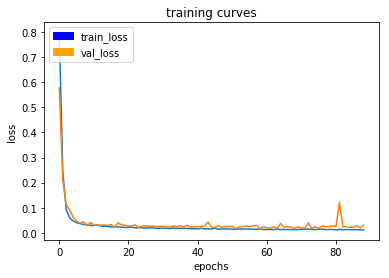

129/129 [==============================] - 65s - loss: 0.0115 - val_loss: 0.0301
Epoch 90/100
128/129 [============================>.] - ETA: 0s - loss: 0.0116

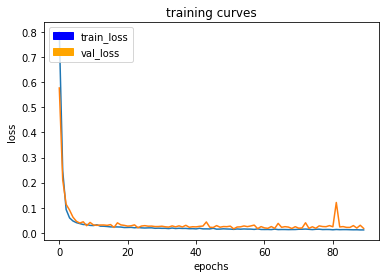

129/129 [==============================] - 65s - loss: 0.0116 - val_loss: 0.0176
Epoch 91/100
128/129 [============================>.] - ETA: 0s - loss: 0.0117

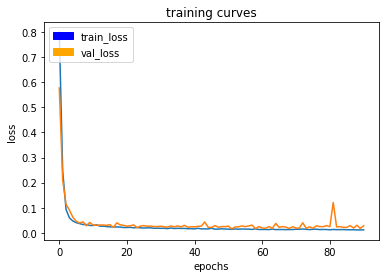

129/129 [==============================] - 65s - loss: 0.0117 - val_loss: 0.0280
Epoch 92/100
128/129 [============================>.] - ETA: 0s - loss: 0.0132

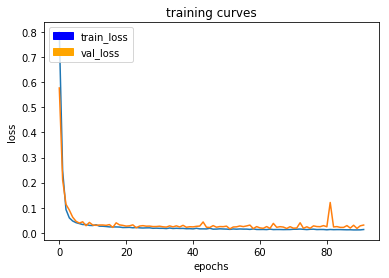

129/129 [==============================] - 65s - loss: 0.0132 - val_loss: 0.0309
Epoch 93/100
128/129 [============================>.] - ETA: 0s - loss: 0.0121

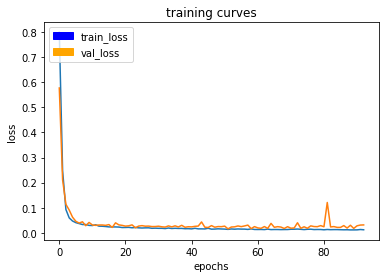

129/129 [==============================] - 65s - loss: 0.0121 - val_loss: 0.0315
Epoch 94/100
128/129 [============================>.] - ETA: 0s - loss: 0.0125

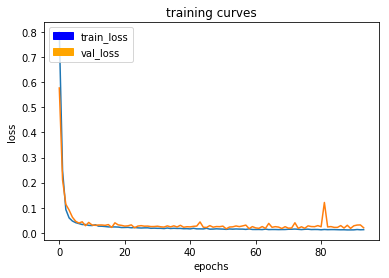

129/129 [==============================] - 65s - loss: 0.0126 - val_loss: 0.0200
Epoch 95/100
128/129 [============================>.] - ETA: 0s - loss: 0.0115

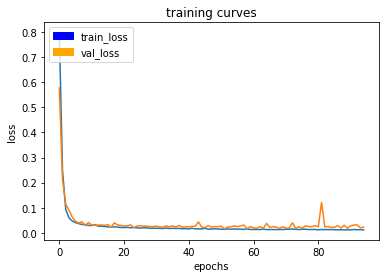

129/129 [==============================] - 65s - loss: 0.0115 - val_loss: 0.0224
Epoch 96/100
128/129 [============================>.] - ETA: 0s - loss: 0.0118

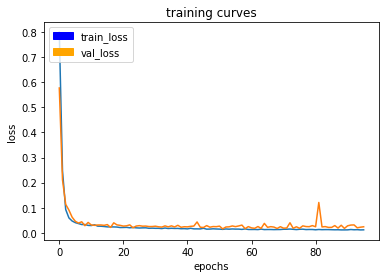

129/129 [==============================] - 65s - loss: 0.0118 - val_loss: 0.0240
Epoch 97/100
128/129 [============================>.] - ETA: 0s - loss: 0.0110

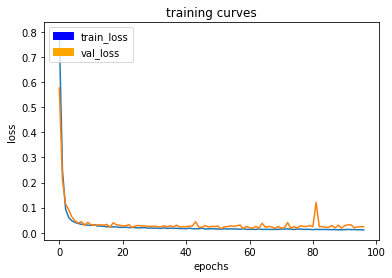

129/129 [==============================] - 65s - loss: 0.0110 - val_loss: 0.0236
Epoch 98/100
128/129 [============================>.] - ETA: 0s - loss: 0.0111

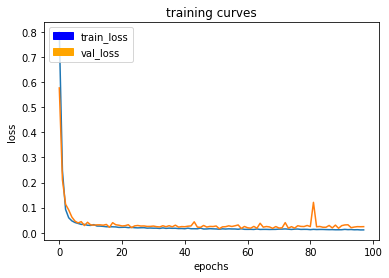

129/129 [==============================] - 65s - loss: 0.0111 - val_loss: 0.0240
Epoch 99/100
128/129 [============================>.] - ETA: 0s - loss: 0.0112

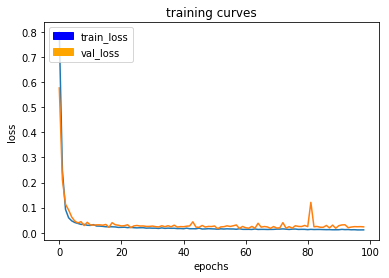

129/129 [==============================] - 65s - loss: 0.0112 - val_loss: 0.0232
Epoch 100/100
128/129 [============================>.] - ETA: 0s - loss: 0.0113

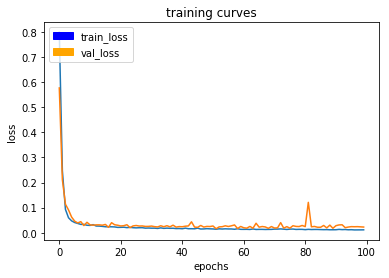

129/129 [==============================] - 65s - loss: 0.0113 - val_loss: 0.0224


In [629]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               #data_folder=os.path.join('..', 'data', 'processed_sim_data', 'train'),
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             #data_folder=os.path.join('..', 'data', 'processed_sim_data', 'validation'),
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [630]:
# Save your trained model weights
weight_file_name = 'model_weights.h5'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [631]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [632]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

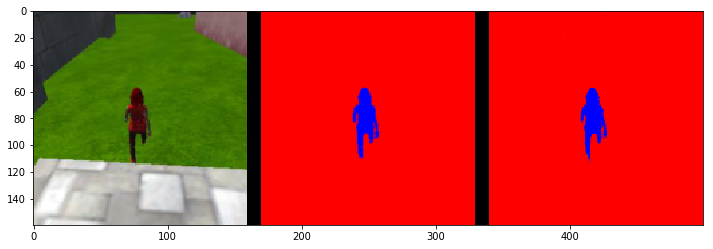

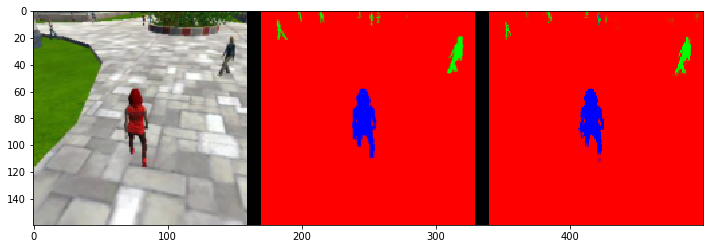

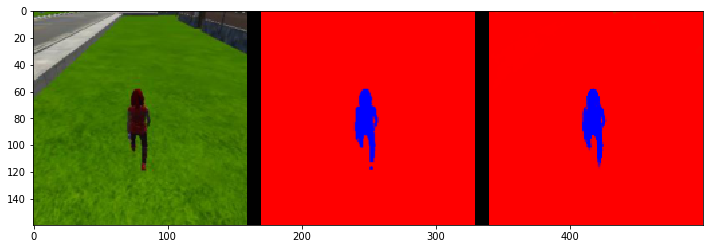

In [633]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

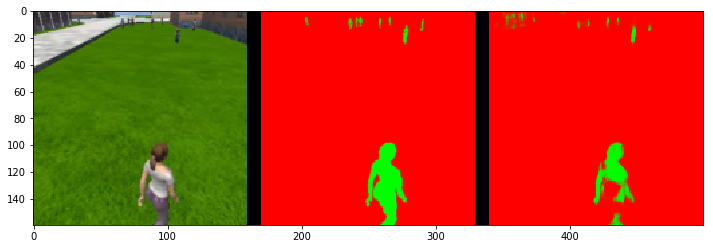

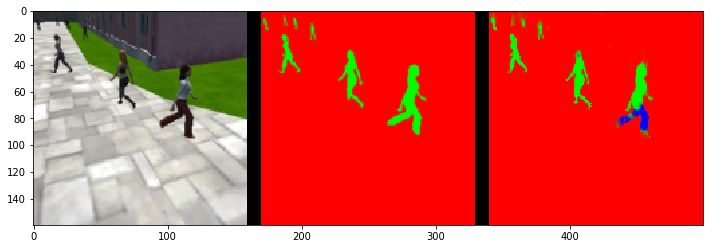

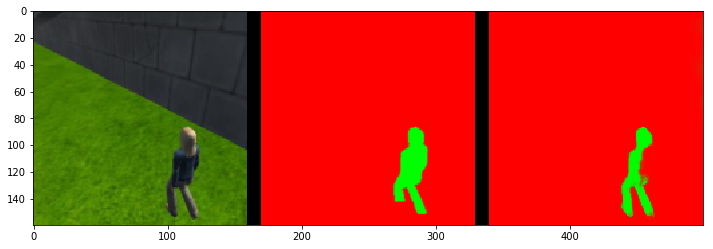

In [634]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

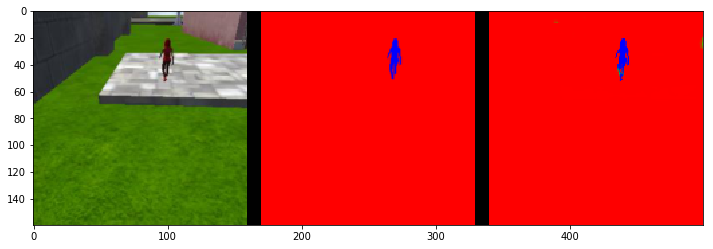

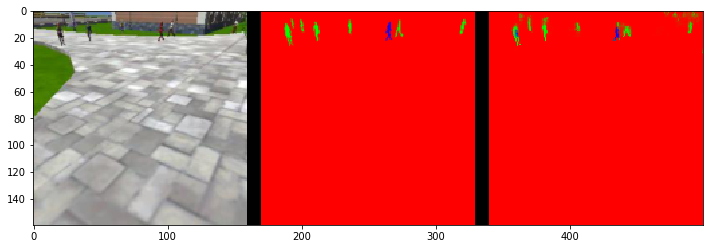

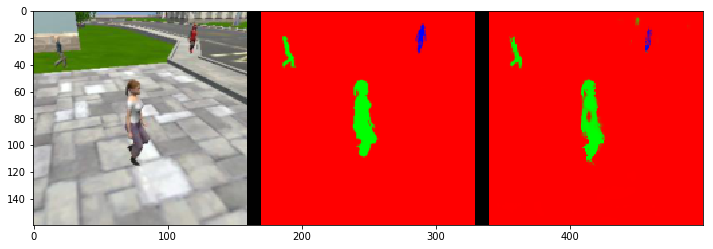

In [635]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [636]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9962025434943333
average intersection over union for other people is 0.3932459828376012
average intersection over union for the hero is 0.9207255077405868
number true positives: 539, number false positives: 0, number false negatives: 0


In [637]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9892762664964551
average intersection over union for other people is 0.7797049205767613
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 55, number false negatives: 0


In [638]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9969109985334772
average intersection over union for other people is 0.4738670108091648
average intersection over union for the hero is 0.2831798892252788
number true positives: 158, number false positives: 2, number false negatives: 143


In [639]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7770345596432553


In [640]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.601952698483


In [641]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.467738049992
